In [47]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, Plots, CSV, DataFrames, CairoMakie
import Base: diff

# Trogdon Code
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n # array from -L to L leaving out L

F = c -> (-6) .* mfft(mifft(c) .* mifft(D*c))

#87 (generic function with 1 method)

## Functions

In [2]:
function rk4(a, t, dt) 
    f1 = exp(D.^3 * t) * F(exp(-D.^3 * t) * a)
    f2 = exp(D.^3 * (t+dt/2)) * F(exp(-D.^3 * (t+dt/2)) * (a+(dt/2)*f1))
    f3 = exp(D.^3 * (t+dt/2)) * F(exp(-D.^3 * (t+dt/2)) * (a+(dt/2)*f2))
    f4 = exp(D.^3 * (t+dt)) * F(exp(-D.^3 * (t+dt)) * (a+dt*f3))
    a = a + (dt/6)*(f1+2*f2+2*f3+f4)
    return a
end

rk4 (generic function with 1 method)

In [3]:
function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A(p)
        a = (r'*r)/(p'*q)
        x += a*p
        r_old = r
        r += - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    x
end

CG (generic function with 1 method)

In [4]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end   

## Data

In [7]:
# T = 5, one soliton
data = Array(CSV.read("out.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

In [23]:
# T = 5, two solitons
data = Array(CSV.read("out-new.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

In [5]:
# T = 50, one soliton
data = Array(CSV.read("out-longtime-50.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

In [5]:
# T = 150, one soliton
data = Array(CSV.read("out-longtime-150.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

## Undamped solution

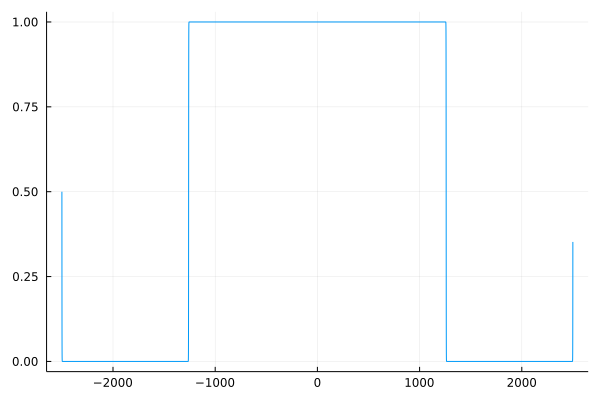

In [6]:
# plot of periodic problem
x_vals = mgrid(2^14, 600)

L = 2500
m = 2^14
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

ℓ1 = -L + (L/2) - 10
ℓ2 = L
σ = x -> 1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1))
γ = x -> 1 .- σ(-x) .- σ(x)

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
plot(X,γ(X),label = false)

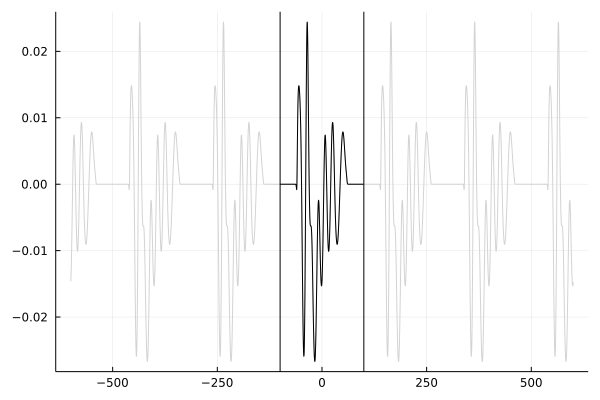

In [7]:
u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt));

for i = 1:steps
    a = rk4(c,dt/2,dt/2)
    c_til = exp(-D.^3*dt/2) * a
    c_bar = CG(B, A(c_til), 1e-10)
    a = rk4(c_bar,dt/2,dt/2)
    c = exp(-D.^3*dt/2) * a 
    
    if isinteger(i / 1000)
        func_vals = mifft(c) .* γ(X)
        c = mfft(func_vals)
    end
    t += dt
end

fm = trig_interp(L,c)
undamped_sol = map(fm,x_vals) |> real;

plot(x_vals, undamped_sol, label = false, line = :lightgrey)
plot!([-L,L], seriestype = :vline, line = :black, label = false)
plot!(X,mifft(c) |> real, label = false, line = :black)

In [7]:
L = 2500
m = 2^14
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt));

@time begin

for i = 1:steps
    a = rk4(c,dt,dt)
    c = exp(-D.^3*dt) * a
    t += dt
end

fm = trig_interp(L,c)
undamped_sol = map(fm,x_vals) |> real;

end

error = maximum(abs.(true_sol .- undamped_sol)) |> rnd 

164.881218 seconds (14.50 M allocations: 425.637 GiB, 8.02% gc time, 0.28% compilation time)


LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 2000 and 16384")

In [19]:
undamped_sol = map(fm,x_vals) |> real;
error = maximum(abs.(true_sol .- undamped_sol)) |> rnd 

0.00091

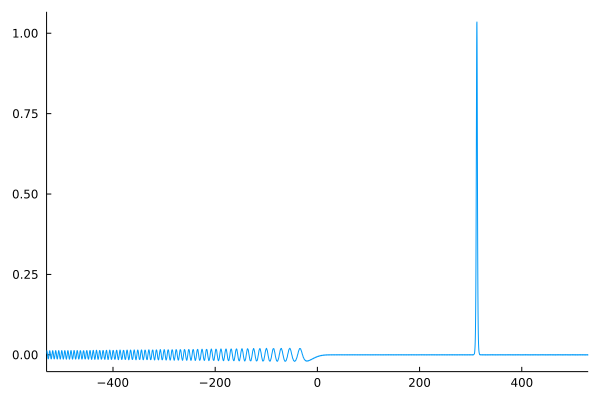

In [31]:
plot(X,mifft(c) |> real, xaxis = [-500,500], label = false,grid=false)
#savefig("fig10")

In [23]:
ϵ = 10^(-3);
errors = abs.(undamped_sol .- true_sol) |> rnd

i = 1;
j = 1;
k = 1;
plots = 0;
plot(x_vals, true_sol, line = :black, linewidth = 0.8, label = "true solution", yaxis=[-0.2,1])

while j < length(errors)  
    i = k;
    while errors[i] > ϵ && i < length(errors)
        i += 1
    end
    
    k = i;
    
    if i != length(errors)
        x_min = x_vals[i];
        
        while errors[k] < ϵ && k < length(errors)
            k += 1
        end
        x_max = x_vals[k];
        
        if (x_max - x_min) > 10
            if plots == 0
                plot!(x_vals[j:i], undamped_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                plot!(x_vals[i:k], undamped_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = "undamped solution valid")
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [Int(round(x_min)),Int(round(x_max)),0])
            else
                plot!(x_vals[j:i], undamped_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                plot!(x_vals[i:k], undamped_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = false)
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [Int(round(x_min)),Int(round(x_max)),0])
            end
            plots = 1;
        else
            plot!(x_vals[j:k], undamped_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
        end
    else
        plot!(x_vals[j:k], undamped_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = "undamped solution")
    end
    j = k;
end

plot!(x_vals, true_sol, line = :black, linewidth = 0.8, label = false)
savefig("undampedgood")

In [66]:
Int(round(83.75))

84

## Regular damping with sigma

In [6]:
L = 200
m = 2^10
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

ℓ1 = -L + (L/2) - 10
ℓ2 = L
γ = 1
σ = x ->  (1 .- (0.5*(tanh.((x.-ℓ1)*γ) .+ 1) + 0.5*(tanh.((-x.-ℓ2)*γ) .+ 1)))

plot(X,σ(X), legend = false)
savefig("fig3")

In [7]:
Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))

u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 50.0
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

@time begin

for i = 2:steps+1
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
    else
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-D.^3*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-D.^3*dt/2) * a 
    end
    t += dt
end

fm = trig_interp(L,c)
    
end

# error
my_sol = map(fm,x_vals) |> real
error = maximum(abs.(true_sol .- my_sol)) |> rnd

 27.435077 seconds (14.18 M allocations: 29.888 GiB, 26.04% gc time, 1.49% compilation time)


0.00077

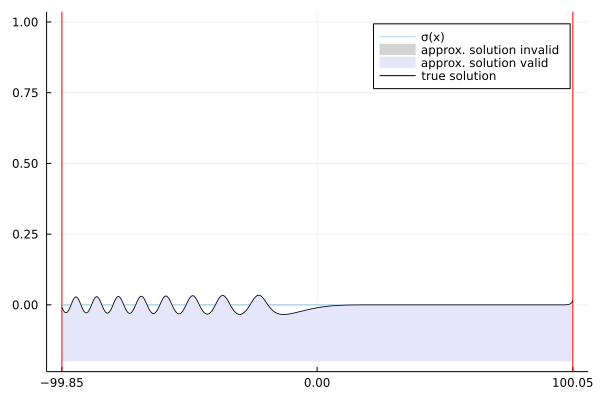

In [8]:
ϵ = 10^(-3)
errors = abs.(true_sol .- my_sol)

plot(x_vals, σ(x_vals), line = :lightblue, linewidth = 1.5, label = "σ(x)", yaxis = [-0.2,1])

i = 1;
j = 1;
k = 1;
plots = 0;

while j < length(errors)  
    i = k;
    while errors[i] > ϵ && i < length(errors)
        i += 1
    end
    
    k = i;
    
    if i == length(errors)
        plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
    else
        x_min = x_vals[i];
        
        while errors[k] < ϵ && k < length(errors)
            k += 1
        end
        x_max = x_vals[k];
        
        if (x_max - x_min) > 10
            if plots == 0
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = "approx. solution invalid")
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = "approx. solution valid")
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            else
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = false)
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            end
            plots = 1;
        else
            plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
        end
    end
    j = k;
end

plot!(x_vals, true_sol, line = :black, linewidth = 0.8, label = "true solution")

## Damping with gamma and sigma

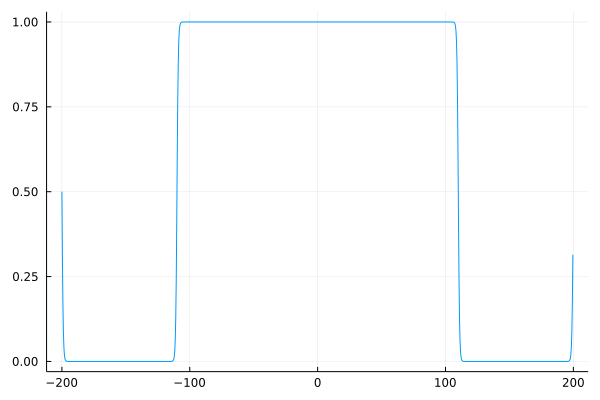

In [107]:
L = 200
m = 2^10
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

k_1 = 100

ℓ1 = -L + (L/2) - 10
ℓ2 = L
σ1 = x -> 1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1))
σ2 = x -> σ1(x) .+ σ1(-x)
γ = x -> 1 .- σ2(-x)
σ = x -> k_1 * σ1(x)

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
plot(X,γ(X),label = false)
#savefig("fig4")

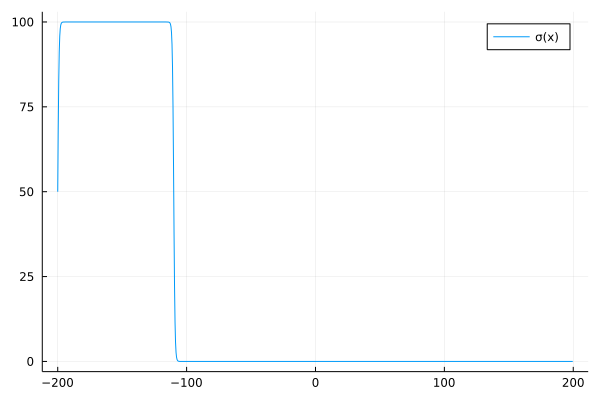

In [108]:
plot(X,σ(X),label = "σ(x)")
#savefig("fig3")

In [115]:
u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

@time begin

for i = 2:steps+1
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
    else     
        if isinteger(i / 500)
            a = rk4(c,dt/2,dt/2)
            c_til = exp(-D.^3*dt/2) * a
            c_bar = CG(B, A(c_til), 1e-10)
            a = rk4(c_bar,dt/2,dt/2)
            c = exp(-D.^3*dt/2) * a 
        else
            a = rk4(c,dt,dt)
            c = exp(-D.^3*dt) * a
        end
            
        # delete the RHS
        if isinteger(i / 1000)
            func_vals = mifft(c) .* γ(X)
            c = mfft(func_vals)
        end
    end           
    t += dt
end

fm = trig_interp(L,c)
my_sol = map(fm,x_vals) |> real
    
end

error = maximum(abs.(true_sol .- my_sol)) |> rnd

 77.858843 seconds (8.95 M allocations: 27.870 GiB, 40.69% gc time)


0.00069

In [29]:
set1 = my_sol; # k_1 = 1, f_1 = 1

In [34]:
set2 = my_sol; # k_1 = 10, f_1 = 100

In [42]:
set3 = my_sol; # k_1 = 20, f_1 = 100, f_2 = 500

In [104]:
set4 = my_sol; # k_1 = 50, f_1 = 200, f_2 = 1000 (gamma is even)

In [116]:
set5 = my_sol; # k_1 = 100, f_1 = 500, f_2 = 1000 (gamma is even)

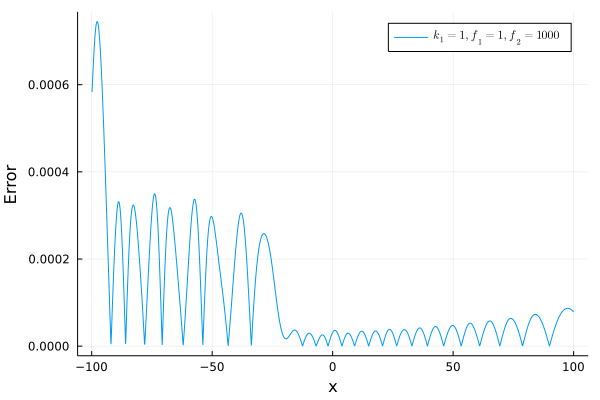

In [87]:
plot(x_vals, abs.(true_sol .- set1), label = "\$ k_1 = 1, f_1 = 1, f_2 = 1000 \$", xlabel = "x", ylabel = "Error")

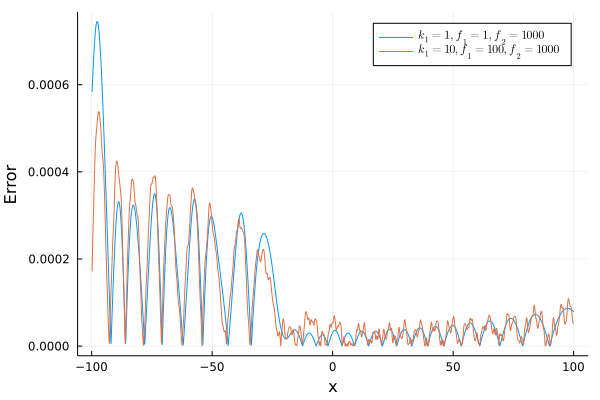

In [88]:
plot!(x_vals, abs.(true_sol .- set2), label = "\$ k_1 = 10, f_1 = 100, f_2 = 1000 \$")

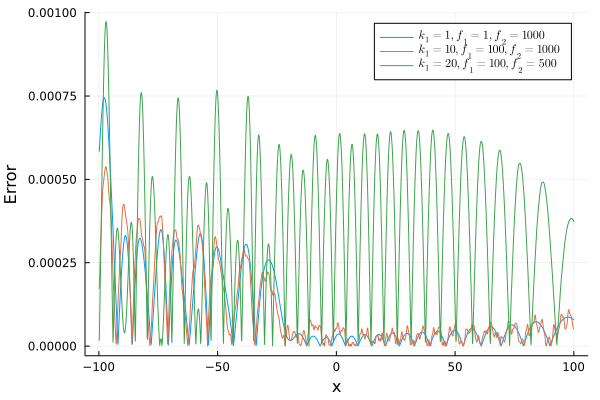

In [89]:
plot!(x_vals, abs.(true_sol .- set3), label = "\$ k_1 = 20, f_1 = 100, f_2 = 500 \$")

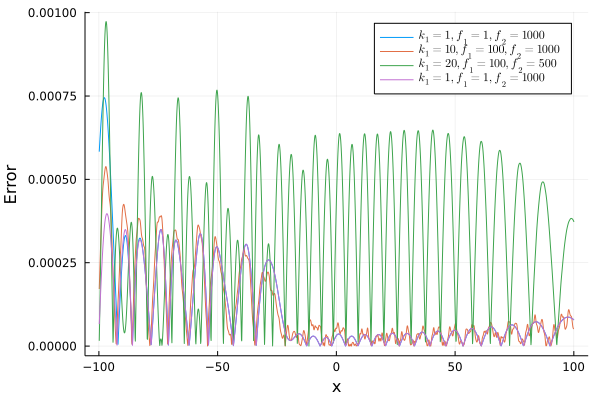

In [90]:
plot!(x_vals, abs.(true_sol .- set4), label = "\$ k_1 = 1, f_1 = 1, f_2 = 1000 \$")

In [46]:
savefig("diffparams")

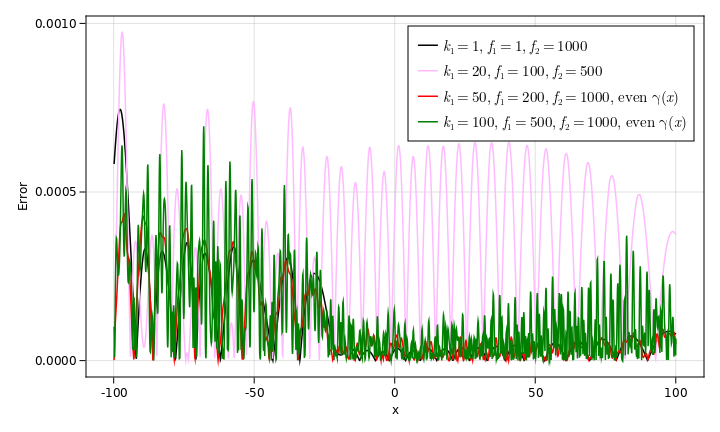

In [117]:
# CairoMakie plot
size_inches = (10, 6)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12)
ax = Axis(fig[1,1])
ax.xlabel = "x"
ax.ylabel = "Error"
lines!(ax, x_vals, abs.(true_sol .- set1), label = L"k_1 = 1,\; f_1 = 1,\; f_2 = 1000", color = :black)
#lines!(ax, x_vals, abs.(true_sol .- set2), label = L"k_1 = 10,\; f_1 = 100,\; f_2 = 1000", aspect_ratio = 90, color = :green)
lines!(ax, x_vals, abs.(true_sol .- set3), label = L"k_1 = 20,\; f_1 = 100,\; f_2 = 500", color = :plum1)
lines!(ax, x_vals, abs.(true_sol .- set4), label = L"k_1 = 50,\; f_1 = 200,\; f_2 = 1000,\; \mathrm{even}\; \gamma(x)", color = :red)
lines!(ax, x_vals, abs.(true_sol .- set5), label = L"k_1 = 100,\; f_1 = 500,\; f_2 = 1000,\; \mathrm{even}\; \gamma(x)", color = :green)
axislegend(ax; labelsize = 15)
fig
#save("diffparams.pdf", fig, pt_per_unit = 1)

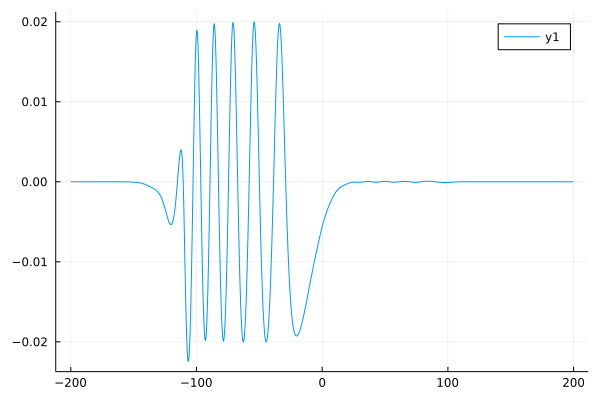

In [17]:
plot(X,mifft(c) |> real)

In [121]:
error = abs(maximum(true_sol .- my_sol)) |> rnd

0.0073

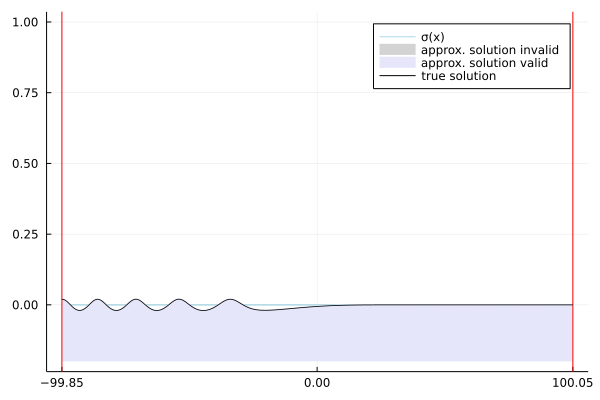

In [124]:
ϵ = 10^(-3)
errors = abs.(true_sol .- my_sol)

plot(x_vals, σ(x_vals), line = :lightblue, linewidth = 1.5, label = "σ(x)", yaxis = [-0.2,1])

i = 1;
j = 1;
k = 1;
plots = 0;

while j < length(errors)  
    i = k;
    while errors[i] > ϵ && i < length(errors)
        i += 1
    end
    
    k = i;
    
    if i == length(errors)
        plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
    else
        x_min = x_vals[i];
        
        while errors[k] < ϵ && k < length(errors)
            k += 1
        end
        x_max = x_vals[k];
        
        if (x_max - x_min) > 10
            if plots == 0
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = "approx. solution invalid")
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = "approx. solution valid")
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            else
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = false)
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            end
            plots = 1;
        else
            plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
        end
    end
    j = k;
end

plot!(x_vals, true_sol, line = :black, linewidth = 0.8, label = "true solution")
#savefig("fig2")

## Damping with just gamma

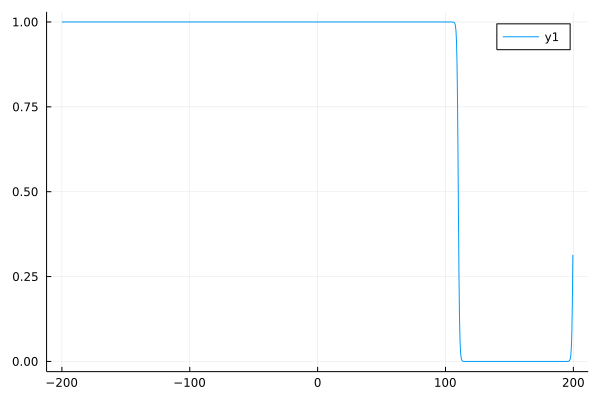

In [63]:
L = 200
m = 2^10
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

ℓ1 = -L + (L/2) - 10
ℓ2 = L
σ = x -> (1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1)))
γ = x -> 1 .- σ(-x)

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
plot(X,γ(X))

In [ ]:
u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

@time begin

for i = 2:steps+1 # using double bump sigma
    a = rk4(c,dt,dt)
    c = exp(-D.^3*dt) * a
        
    # delete the RHS
    if isinteger(i / 1000)
        func_vals = mifft(c) .* γ(X)
        c = mfft(func_vals)
    end         
    t += dt
end

fm = trig_interp(L,c)
my_sol = map(fm,x_vals) |> real
    
end

error = abs(maximum(true_sol .- my_sol)) |> rnd

In [ ]:
ϵ = 10^(-3)
errors = abs.(true_sol .- my_sol)

plot(x_vals, σ(x_vals), line = :lightblue, linewidth = 1.5, label = "σ(x)", yaxis = [-0.2,1])

i = 1;
j = 1;
k = 1;
plots = 0;

while j < length(errors)  
    i = k;
    while errors[i] > ϵ && i < length(errors)
        i += 1
    end
    
    k = i;
    
    if i == length(errors)
        plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
    else
        x_min = x_vals[i];
        
        while errors[k] < ϵ && k < length(errors)
            k += 1
        end
        x_max = x_vals[k];
        
        if (x_max - x_min) > 10
            if plots == 0
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = "approx. solution invalid")
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = "approx. solution valid")
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            else
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = false)
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            end
            plots = 1;
        else
            plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
        end
    end
    j = k;
end

plot!(x_vals, true_sol, line = :black, linewidth = 0.8, label = "true solution")

## Damping with modified sigma

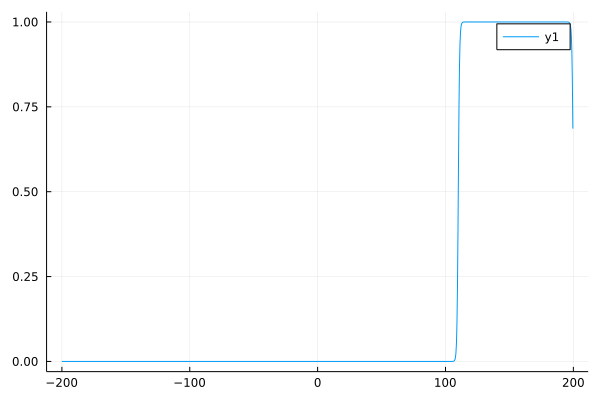

In [51]:
L = 200
m = 2^10
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

ℓ1 = -L + (L/2) - 10
ℓ2 = L
γ = 1
σ = x ->  (1 .- (0.5*(tanh.((x.-ℓ1)*γ) .+ 1) + 0.5*(tanh.((-x.-ℓ2)*γ) .+ 1)))
ψ = x -> σ(-x)

Σ = Diagonal(σ(X))
Ψ = Diagonal(ψ(X))
#A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
#B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x)) - (dt/2)*mfft(Ψ*mifft(x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x)) + (dt/2)*mfft(Ψ*mifft(x))
plot(X,ψ(X))

In [49]:
u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

@time begin

for i = 2:steps+1
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
    else
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-D.^3*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-D.^3*dt/2) * a 
    end           
    t += dt
end

fm = trig_interp(L,c)
my_sol = map(fm,x_vals) |> real
    
end

error = abs(maximum(true_sol .- my_sol)) |> rnd

155.231504 seconds (35.73 M allocations: 107.585 GiB, 16.70% gc time, 0.15% compilation time)


0.03008

In [56]:
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
A_both = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x)) - (dt/2)*mfft(Ψ*mifft(x))
B_both = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x)) + (dt/2)*mfft(Ψ*mifft(x))

u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

@time begin

for i = 2:steps+1
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
    else
        if isinteger(i / 1000)
            a = rk4(c,dt/2,dt/2)
            c_til = exp(-D.^3*dt/2) * a
            c_bar = CG(B_both, A_both(c_til), 1e-10)
            a = rk4(c_bar,dt/2,dt/2)
            c = exp(-D.^3*dt/2) * a 
        else
            a = rk4(c,dt/2,dt/2)
            c_til = exp(-D.^3*dt/2) * a
            c_bar = CG(B, A(c_til), 1e-10)
            a = rk4(c_bar,dt/2,dt/2)
            c = exp(-D.^3*dt/2) * a 
        end
    end           
    t += dt
end

fm = trig_interp(L,c)
my_sol = map(fm,x_vals) |> real
    
end

error = abs(maximum(true_sol .- my_sol)) |> rnd

127.492854 seconds (28.46 M allocations: 89.854 GiB, 15.18% gc time, 0.24% compilation time)


0.01183

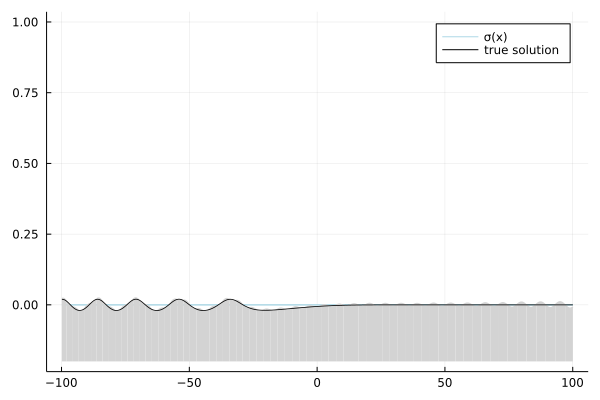

In [57]:
ϵ = 10^(-3)
errors = abs.(true_sol .- my_sol)

plot(x_vals, σ(x_vals), line = :lightblue, linewidth = 1.5, label = "σ(x)", yaxis = [-0.2,1])

i = 1;
j = 1;
k = 1;
plots = 0;

while j < length(errors)  
    i = k;
    while errors[i] > ϵ && i < length(errors)
        i += 1
    end
    
    k = i;
    
    if i == length(errors)
        plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
    else
        x_min = x_vals[i];
        
        while errors[k] < ϵ && k < length(errors)
            k += 1
        end
        x_max = x_vals[k];
        
        if (x_max - x_min) > 10
            if plots == 0
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = "approx. solution invalid")
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = "approx. solution valid")
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            else
                plot!(x_vals[j:i], my_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                plot!(x_vals[i:k], my_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = false)
                plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [x_min,x_max,0])
            end
            plots = 1;
        else
            plot!(x_vals[j:k], my_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
        end
    end
    j = k;
end

plot!(x_vals, true_sol, line = :black, linewidth = 0.8, label = "true solution")